Tutorial 1: Model Mapping
=========================

In this tutorial, we'll parameterize a simple model and use **PyAutoFit** to map its parameters to a model instance,
which we'll fit to data in the next tutorial.

In [1]:
import autofit as af
import numpy as np
import matplotlib.pyplot as plt

**PyAutoFit** assumes the current working directory is `/path/to/autofit_workspace/` on your hard-disk. This is so 
that it can:
 
 - Load configuration settings from config files in the `autofit_workspace/config` folder.
 - Load example data from the `autofit_workspace/dataset` folder.
 - Output the results of models fits to your hard-disk to the `autofit/output` folder. 

If you don't have an autofit_workspace (perhaps you cloned / forked the **PyAutoLens** GitHub repository?) you can
download it here:
 
 https://github.com/Jammy2211/autofit_workspace

At the top of every tutorial notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.

In [2]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


Throughout these tutorials we will fit 1D noisy data containing a Gaussian. These are loaded from .json files, where:

 - The data is a 1D numpy array of values corresponding to the observed counts of the Gaussian.
 - The noise-map corresponds to the expected noise in every data point.
 
These datasets were created using the scripts in `autofit_workspace/howtofit/simulators`, feel free to check them out!

When you adapt your own modeling software to use **PyAutoFit**, your dataset folder will contain the data
specific to your project.

In [3]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Lets plot the `Gaussian` using Matplotlib. 

The `Gaussian` is on a line of xvalues, which we'll compute using the shape of the `Gaussian` data and plot on the 
x-axis. These xvalues will be used in later tutorials to create and fit Gaussians to the data.

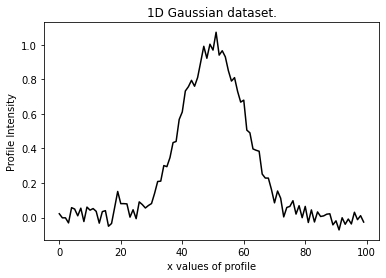

In [4]:
xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()

We can also plot its `noise_map` (which in this example are all constant values) as a standalone 1D plot or
as error bars on the `data`.

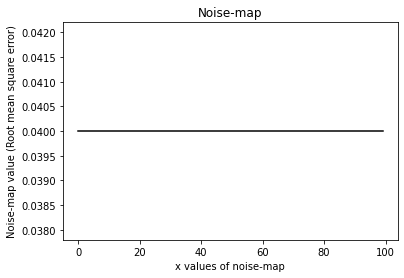

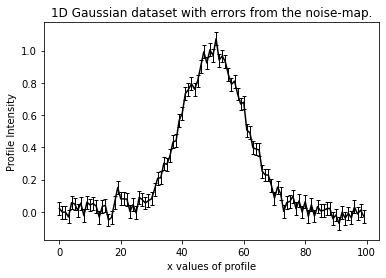

In [5]:
plt.plot(xvalues, noise_map, color="k")
plt.title("Noise-map")
plt.xlabel("x values of noise-map")
plt.ylabel("Noise-map value (Root mean square error)")
plt.show()

plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()

Its not until tutorial 3 that we'll actually fit this image with a model. But its worth us looking at it now so we
can understand the model we're going to fit. So what is the model?

Clearly, its a one-dimensional `Gaussian` defined as:

\begin{equation*}
g(x, I, \sigma) = \frac{I}{\sigma\sqrt{2\pi}} \exp{(-0.5 (x / \sigma)^2)}
\end{equation*}

Where:

x - Is x-axis coordinate where the `Gaussian` is evaluated.
I - Describes the intensity of the Gaussian.
$\sigma$ - Describes the size of the Gaussian.

This simple equation describes our model, a 1D `Gaussian`, and it has 3 parameters, $(x, I, \sigma)$. Using different
values of these 3 parameters we can describe *any* possible 1D Gaussian.

At its core, **PyAutoFit** is all about making it simple to define a model and straight forwardly map a set of input
parameters to the model.

We now want to create our model of a 1D Gaussian. We've done this in the following module:

`autofit_workspace/howtofit/chapter_1_introduction/gaussian.py`

Look at this file now to see a description of our `Gaussian` class, which we will use throughout these
tutorials as a `model_component`.

The class`s format is how **PyAutoFit** requires the components of a model to be written, where:

- The name of the class is the name of the model component, in this case, "Gaussian".

- The input arguments of the constructor are the model parameters which we will ultimately fit for, in this case the
  `centre`, `intensity` and `sigma`.
  
- The default values of the input arguments tell **PyAutoFit** whether a parameter is a single-valued float or a 
  multi-valued tuple. For the `Gaussian` class, no input parameters are a tuple and we will show an example of a tuple 
  input in a later tutorial).
  
By writing a model component in this way, we can use the Python class to set it up as model component in **PyAutoFit**.
**PyAutoFit** can then generate model components as instances of their Python class, meaning that its functions 
(e.g. `profile_from_xvalues`) are accessible to **PyAutoFit**.

In [6]:
import gaussian as g

We've written the class in a standalone module (as opposed to this script) because the default priors of the model
are loaded from the `autofit_workspace/config/priors` directory. Specifically, the priors for a class are loaded from a 
.json file with the same name as the module the class is in.

For example, because our `Gaussian` is in the module `gaussian.py`, its priors are loaded from the priors config
file `gaussian.json`. Check this file out now to see the default priors; we'll discuss what the different inputs
mean later on.

To set it up as a model component, we use a `Model` object.

In [7]:
model = af.Model(g.Gaussian)
print("Model `Gaussian` object: \n")
print(model)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0)


As discussed above, the default priors are those set in the `autofit_workspace/config/priors/gaussian.json` file. We 
can manually override the prior for each parameter.

In [8]:
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)
model.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)
model.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)

Using this `Model` we can create an `instance` of the model, by mapping a list of physical values of each 
parameter as follows.

In [9]:
instance = model.instance_from_vector(vector=[1.0, 2.0, 3.0])

This is an instance of the `Gaussian` class.

In [10]:
print("Model Instance: \n")
print(instance)

Model Instance: 



It has the parameters of the `Gaussian` with the values input above.

In [11]:
print("Instance Parameters \n")
print("x = ", instance.centre)
print("intensity = ", instance.intensity)
print("sigma = ", instance.sigma)

Instance Parameters 

x =  1.0
intensity =  2.0
sigma =  3.0


Congratulations! You`ve defined your first model in **PyAutoFit**! :)

So, why is it called a `Model`?

The parameters of a `Model` in **PyAutoFit** all have a prior associated with them. Priors encode our expectations 
on what values we expect each parameter can have. For example, we might know that our `Gaussian` will be centred near 
0.0.

__How Are Priors Used?__

Priors are used to create model instances from a unit-vector, which is a vector defined in the same way as the vector 
above but with values spanning from 0 -> 1.

Unit values are mapped to physical values via the prior, for example:

For a UniformPrior defined between 0.0 and 10.0:

- An input unit value of 0.5 will give the physical value 5.0.
- An input unit value of 0.8 will give te physical value 8.0.

For a LogUniformPrior (base 10) defined between 1.0 and 100.0:

- An input unit value of 0.5 will give the physical value 10.0.
- An input unit value of 1.0 will give te physical value 100.0.

For a GauassianPrior defined with mean 1.0 and sigma 1.0:

- An input unit value of 0.5 (e.g. the centre of the Gaussian) will give the physical value 1.0.
- An input unit value of 0.8173 (e.g. 1 sigma confidence) will give te physical value 1.9051.

Lets take a look:

In [12]:
model.centre = af.UniformPrior(lower_limit=10.0, upper_limit=20.0)
model.intensity = af.GaussianPrior(mean=5.0, sigma=7.0)
model.sigma = af.LogUniformPrior(lower_limit=1.0, upper_limit=100.0)

These priors are now used to map our unit values to physical values when we create an instance of the Gaussian
class.

In [13]:
instance = model.instance_from_unit_vector(unit_vector=[0.5, 0.3, 0.8])

Lets check that this instance is again an instance of the `Gaussian` class.

In [14]:
print("Model Instance: \n")
print(instance)

Model Instance: 



It now has physical values for the parameters mapped from the priors defined above.

In [15]:
print("Instance Parameters \n")
print("x = ", instance.centre)
print("intensity = ", instance.intensity)
print("sigma = ", instance.sigma)

Instance Parameters 

x =  15.0
intensity =  1.3291964110437147
sigma =  39.810717055349734


We can also set physical limits on parameters, such that a model instance cannot generate parameters outside of a
specified range.

For example, a `Gaussian` cannot have a negative intensity, so we can set its lower limit to a value of 0.0.

This is what the `gaussian_limits` section in the priors config files sets.

In [16]:
model.intensity = af.GaussianPrior(
    mean=0.0, sigma=1.0, lower_limit=0.0, upper_limit=1000.0
)

The unit vector input below creates a negative intensity value, such that if you uncomment the line below **PyAutoFit** 
raises an error.

In [17]:
# instance = model.instance_from_unit_vector(unit_vector=[0.01, 0.01, 0.01])

And with that, you`ve completed tutorial 1!

At this point, you might be wondering, whats the big deal? Sure, its cool that we set up a model and its nice that
we can translate priors to parameters in this way, but how is this actually going to help me perform model fitting?
With a bit of effort I could have written some code to do this myself!

Well, you're probably right, but this tutorial is covering just the backend of **PyAutoFit**, what holds everything
together. Once you start using **PyAutoFit**, its unlikely that you'll perform model mapping yourself, its the `magic` 
behind the scenes that makes model-fitting work.

So, we're pretty much ready to move on to tutorial 2, where we'll actually fit this model to some data. However,
first, I want you to quickly think about the model you want to fit. How would you write it as a class using the
**PyAutoFit** format above? What are the free parameters of you model? Are there multiple model components you are 
going to want to fit to your data?

If you decide to add a new model-component to the `autofit_workspace` specific to your model-fitting task, first
checkout the following script, which explains how to set up the **PyAutoFit** configuration files associated with 
your model.

`autofit_workspace/notebooks/overview/new_model_component/new_model_compnent.ipynb`

Below are two more classes one might use to perform model fitting, the first is the model of a linear-regression line
of the form $y = mx + c$ that you might fit to a 1D data-set:

In [18]:


class LinearFit:
    def __init__(self, gradient=1.0, intercept=0.0):

        self.gradient = gradient
        self.intercept = intercept


The second example is a two-dimensional Gaussian. Here, the centre now has two coordinates (y,x), which in 
**PyAutoFit** is more suitably defined using a tuple.

In [19]:


class Gaussian2D:
    def __init__(self, centre=(0.0, 0.0), intensity=0.1, sigma=1.0):

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma
